In [1]:
import pandas as pd
import pickle
from PIL import Image
import numpy as np
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import shelve
import math
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pickle5 as pickle
import scipy.io
from scipy.stats import sem
import dataframe_image as dfi

In [2]:
##dataloader
from torch.utils.data import Dataset, DataLoader

class FaceDataset(Dataset):
    def __init__(self, txt_path, img_dir, transforms = None):
        df = pickle.load(open(txt_path, "rb"))
        df['img'] = df['img'].str.replace("/mmfs1/data/schwarex/neuralNetworks/identity/datasets/img_align_celeba",
                                          img_dir)
        self.txt_path = txt_path
        self.y = df['new_label']
        self.x = df['img']
        self.n_samples = len(df)
        self.transforms = transforms

        self.mu = torch.randn(1503)
        m = torch.distributions.gamma.Gamma(torch.ones(1503), torch.ones(1503) * 20)
        self.sigma = m.sample()

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        image = Image.open(self.x.iloc[index]).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        label = self.y.iloc[index]
        base_reward = torch.randn(1)
        reward = base_reward * self.sigma[label] + self.mu[label]
        data = [image, label, reward]

        return data

    
transform = transforms.Compose([transforms.CenterCrop(178),  #original image size = (178, 218)
                                transforms.Resize(128),
                                transforms.ToTensor()])       
                                                                                                                                                     
train_dataset = FaceDataset(txt_path = '/data/zhouabx/celebA/train_SUBSET.pkl',
                            img_dir = '/mmfs1/data/zhouabx/celebA/img_align_celeba/',
                            transforms = transform)
trainloader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetEncoder(nn.Module):
    def __init__(self, num_blocks, k):
        super(ResNetEncoder, self).__init__()
        self.in_channels = k
        self.conv1 = nn.Conv2d(3, k, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(k)
        self.layer1 = self._make_layer(k, num_blocks[0], stride = 1)       ## 64
        self.layer2 = self._make_layer(k * 2, num_blocks[1], stride = 2)   ## 64 * 2 = 128
        self.layer3 = self._make_layer(k * 4, num_blocks[2], stride = 2)   ## 64 * 4 = 256
        self.layer4 = self._make_layer(k * 8, num_blocks[3], stride = 2)   ## 64 * 8 = 512

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)       
        out = self.layer4(out)
        return out
   
class ResNet18(nn.Module):
    def __init__(self, k):
        super(ResNet18, self).__init__()
        self.encoder = ResNetEncoder([2, 2, 2, 2], k)
        
        # id classifier 
        self.classifier = nn.Sequential(
            nn.Linear(512, 1503)
        )

    def forward(self, x):
        feature_map = self.encoder(x)
        x = F.adaptive_avg_pool2d(feature_map, (1, 1))
        x = x.view(x.size(0), -1)
        classification = self.classifier(x)
        return x, classification

ResModel = ResNet18(64)
ResModel.cuda()

ResNet18(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [4]:
checkpoint = torch.load('/mmfs1/data/zhouabx/ResNet-18/ResNet_gender/id/test_CelebA_train_results/RGB_ResNet_ID.ckp',
                        map_location = 'cpu')
ResModel.load_state_dict(checkpoint['ResModel_state_dict'])

<All keys matched successfully>

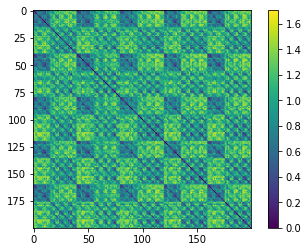

In [8]:
#test on KDEF dataset subset B (note that this is described as dataset A in the paper, and vice versa the dataset that is described as dataset B in the paper is named dataset A in the code)

Dataset_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_B_with_id_expression_direction.pkl', "rb"))   

KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

feature_list_B = []
ResModel.eval()
with torch.no_grad():
    for idx, row in Dataset_B.iterrows():
        image = Image.open(Dataset_B['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        x, classification = ResModel(image[None, :].cuda())      
        feature_list_B.append(x[0, :])      
B_features = torch.stack((feature_list_B))

#label everything
dictionary_emotion = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
Dataset_B['emotionlabel'] = Dataset_B['expression'].map(dictionary_emotion)

dictionary_view = {'FL' : 0, 'FR' : 1, 'HL' : 2, 'HR' : 3, 'S' : 4}
Dataset_B['viewlabel'] = Dataset_B['direction'].map(dictionary_view)

dictionary_id = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AM08' : 4, 'AM10' : 5, 'AM11' : 6, 'AM25': 7}
Dataset_B['idlabel'] = Dataset_B['id'].map(dictionary_id)

#add feature to the dataset
Dataset_B['feature_B'] = B_features.cpu().detach()

#order everything
New_Data_B = Dataset_B.sort_values(by = ['emotionlabel', 'viewlabel', 'idlabel'])
#reset the index and save the dataframe in New_Data_B_with_feature
New_Data_B_with_features = New_Data_B.reset_index(drop = True)

# create array features
array_features_B = [New_Data_B_with_features['feature_B'][0]]
for i in range(1, New_Data_B_with_features.shape[0]):
    array_features_B = np.concatenate((array_features_B, [New_Data_B_with_features['feature_B'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_B, axis = 0)
centered_data = array_features_B - average_vector

# attach centered_feature
New_Data_B_with_features['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

# create RDM
l = [None] * 200
for _ in range (len(New_Data_B_with_features)):
    l [New_Data_B_with_features.iloc[_]['idlabel'] + 
       8 * New_Data_B_with_features.iloc[_]['viewlabel'] + 
       8 * 5 * New_Data_B_with_features.iloc[_]['emotionlabel']] = New_Data_B_with_features.iloc[_]['centered_feature']

RDM_B = 1 - np.corrcoef(l)

plt.imshow(RDM_B) ## note that this is named RDM A in the paper
plt.colorbar()

In [9]:
#save RDM value
path = "/data/zhouabx/ResNet-18/ResNet_gender/id/RGB_KDEF_test_results_AB/"
with open(path + 'RDM_value_B.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_B, pickle_out)

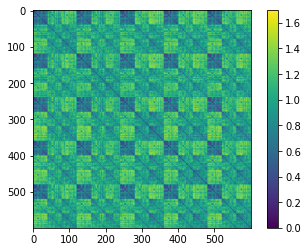

In [10]:
Dataset_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_A_with_id_expression_direction.pkl', "rb"))
KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])


features_list_A = []
ResModel.eval()
with torch.no_grad():
    for idx, row in Dataset_A.iterrows():
        image = Image.open(Dataset_A['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        x, classification = ResModel(image[None, :].cuda())
        features_list_A.append(x[0, :])
A_features = torch.stack((features_list_A))
        
Dataset_A['feature_A'] = A_features.cpu().detach()
Dataset_A_with_features = Dataset_A  

#average the L and R         
Dataset_A_with_features["new_direction"] = np.where((Dataset_A_with_features["direction"].values == "HR") | (Dataset_A_with_features["direction"] == "HL"), 
         "H", 
         np.where((Dataset_A_with_features["direction"].values == "FR") | (Dataset_A_with_features["direction"] == "FL"), 
         "F", 
         Dataset_A_with_features["direction"].values))        
         

group_index = Dataset_A_with_features.agg('{0[expression]} and {0[new_direction]} and {0[id]}'.format, axis = 1)

ids = np.unique(group_index)
g_mean = np.array([np.mean(A_features.cpu().detach().numpy()[group_index == i, 0:], axis = 0) for i in ids])

df_LR_ave = pd.DataFrame(data = np.array(list(map(lambda x : np.str.split(x, sep = " and "), ids))))
df_LR_ave.columns = ["expression", "direction", "id"]
df_LR_ave['feature_A'] = g_mean.tolist()
                
#label everything
dictionary_emotion_A = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
df_LR_ave['emotionlabel_A'] = df_LR_ave['expression'].map(dictionary_emotion_A)

dictionary_view_A = {'F' : 0, 'H' : 1, 'S' : 2}
df_LR_ave['viewlabel_A'] = df_LR_ave['direction'].map(dictionary_view_A)

dictionary_id_A = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AF06' : 4, 'AF07' : 5, 'AF09' : 6, 'AF13' : 7, 'AF14' : 8, 'AF16' : 9,
 'AF20' : 10, 'AF21' : 11, 'AF22' : 12, 'AF24' : 13, 'AF25': 14, 'AF28' : 15, 'AF29' : 16, 'AF30' : 17, 'AF32' : 18, 
 'AF33' : 19, 'AM01' : 20, 'AM05' : 21, 'AM06' : 22, 'AM08' : 23, 'AM09' : 24, 'AM10' : 25, 'AM11' : 26, 'AM13' : 27,
 'AM14' : 28, 'AM15' : 29, 'AM16' : 30, 'AM22' : 31, 'AM23' : 32, 'AM24' : 33, 'AM25' : 34, 'AM28' : 35, 'AM29' : 36,
 'AM30' : 37, 'AM31' : 38, 'AM35' : 39}
df_LR_ave['idlabel_A'] = df_LR_ave['id'].map(dictionary_id_A)

#order everything
New_Data_A = df_LR_ave.sort_values(by = ['emotionlabel_A', 'viewlabel_A', 'idlabel_A'])
#reset the index and save the dataframe in New_Data_A_with_features
New_Data_A_with_features = New_Data_A.reset_index(drop = True)  

# create array features
array_features_A = [New_Data_A_with_features['feature_A'][0]]
for i in range(1, New_Data_A_with_features.shape[0]):
    array_features_A = np.concatenate((array_features_A, [New_Data_A_with_features['feature_A'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_A, axis = 0)
centered_data = array_features_A - average_vector

# attach centered_feature
New_Data_A_with_features['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]


l_A = [None] * 600
for _ in range (len(New_Data_A_with_features)):
    l_A [New_Data_A_with_features.iloc[_]['idlabel_A'] + 
         40 * New_Data_A_with_features.iloc[_]['viewlabel_A'] + 
         40 * 3 * New_Data_A_with_features.iloc[_]['emotionlabel_A']] = New_Data_A_with_features.iloc[_]['centered_feature']      

RDM_A = 1 - np.corrcoef(l_A)      

plt.imshow(RDM_A) ## note that this is named RDM B in the paper
plt.colorbar()

In [11]:
#save RDM value
path = "/data/zhouabx/ResNet-18/ResNet_gender/id/RGB_KDEF_test_results_AB/"
with open(path + 'RDM_value_A.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_A, pickle_out)

In [2]:
# KDEF A & B
RGB_ResID_RDM_value_A = pickle.load(open('/mmfs1/data/zhouabx/ResNet-18/ResNet_gender/id/RGB_KDEF_test_results_AB/RDM_value_A.pkl',"rb"))
v_RGB_ResID_RDM_A = RGB_ResID_RDM_value_A[np.triu_indices(RGB_ResID_RDM_value_A.shape[0], 1)]

RGB_ResID_RDM_value_B = pickle.load(open('/mmfs1/data/zhouabx/ResNet-18/ResNet_gender/id/RGB_KDEF_test_results_AB/RDM_value_B.pkl',"rb"))
v_RGB_ResID_RDM_B = RGB_ResID_RDM_value_B[np.triu_indices(RGB_ResID_RDM_value_B.shape[0], 1)]

In [3]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p16/'
vA_p16_rdms = []
v_vA_p16_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p16_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p16_rdms)):
    vector = vA_p16_rdms[i][np.triu_indices(vA_p16_rdms[i].shape[0], 1)]
    v_vA_p16_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vA_p16 = []
for i in range (len(v_vA_p16_rdms)):   
    kendalltau_RGB_ResID_and_vA_p16.append(stats.kendalltau(v_RGB_ResID_RDM_A, v_vA_p16_rdms[i]))
    
corr, _ = kendalltau_RGB_ResID_and_vA_p16[0]
print('subset A RGB_ResNet_ID and p16_e90_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p16[1]
print('subset A RGB_ResNet_ID and p16_e90_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p16[2]
print('subset A RGB_ResNet_ID and p16_e90_wind6 kendalltau: %.5f' % corr)

subset A RGB_ResNet_ID and p16_e90_wind4 kendalltau: 0.02989
subset A RGB_ResNet_ID and p16_e90_wind5 kendalltau: 0.02105
subset A RGB_ResNet_ID and p16_e90_wind6 kendalltau: 0.01001


In [4]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p23/'
vA_p23_rdms = []
v_vA_p23_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p23_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p23_rdms)):
    vector = vA_p23_rdms[i][np.triu_indices(vA_p23_rdms[i].shape[0], 1)]
    v_vA_p23_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vA_p23 = []
for i in range (len(v_vA_p23_rdms)):   
    kendalltau_RGB_ResID_and_vA_p23.append(stats.kendalltau(v_RGB_ResID_RDM_A, v_vA_p23_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vA_p23[0]
print('subset A RGB_ResNet_ID and p23_wind4 kendalltau: 0')
corr, _ = kendalltau_RGB_ResID_and_vA_p23[1]
print('subset A RGB_ResNet_ID and p23_wind5 kendalltau: 0')
corr, _ = kendalltau_RGB_ResID_and_vA_p23[2]
print('subset A RGB_ResNet_ID and p23_wind6 kendalltau: 0')

subset A RGB_ResNet_ID and p23_wind4 kendalltau: 0
subset A RGB_ResNet_ID and p23_wind5 kendalltau: 0
subset A RGB_ResNet_ID and p23_wind6 kendalltau: 0


In [5]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p27/'
vA_p27_rdms = []
v_vA_p27_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p27_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p27_rdms)):
    vector = vA_p27_rdms[i][np.triu_indices(vA_p27_rdms[i].shape[0], 1)]
    v_vA_p27_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vA_p27 = []
for i in range (len(v_vA_p27_rdms)):   
    kendalltau_RGB_ResID_and_vA_p27.append(stats.kendalltau(v_RGB_ResID_RDM_A, v_vA_p27_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vA_p27[0]
print('subset A RGB_ResNet_ID and p27_e100_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[1]
print('subset A RGB_ResNet_ID and p27_e100_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[2]
print('subset A RGB_ResNet_ID and p27_e100_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[3]
print('subset A RGB_ResNet_ID and p27_e53_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[4]
print('subset A RGB_ResNet_ID and p27_e53_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[5]
print('subset A RGB_ResNet_ID and p27_e53_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[6]
print('subset A RGB_ResNet_ID and p27_e60_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[7]
print('subset A RGB_ResNet_ID and p27_e60_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[8]
print('subset A RGB_ResNet_ID and p27_e60_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[9]
print('subset A RGB_ResNet_ID and p27_e61_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[10]
print('subset A RGB_ResNet_ID and p27_e61_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[11]
print('subset A RGB_ResNet_ID and p27_e61_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[12]
print('subset A RGB_ResNet_ID and p27_e62_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[13]
print('subset A RGB_ResNet_ID and p27_e62_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p27[14]
print('subset A RGB_ResNet_ID and p27_e62_wind6 kendalltau: %.5f' % corr)

subset A RGB_ResNet_ID and p27_e100_wind4 kendalltau: 0.04922
subset A RGB_ResNet_ID and p27_e100_wind5 kendalltau: 0.03110
subset A RGB_ResNet_ID and p27_e100_wind6 kendalltau: 0.00856
subset A RGB_ResNet_ID and p27_e53_wind4 kendalltau: 0.05226
subset A RGB_ResNet_ID and p27_e53_wind5 kendalltau: 0.07871
subset A RGB_ResNet_ID and p27_e53_wind6 kendalltau: 0.04834
subset A RGB_ResNet_ID and p27_e60_wind4 kendalltau: 0.01698
subset A RGB_ResNet_ID and p27_e60_wind5 kendalltau: 0.03395
subset A RGB_ResNet_ID and p27_e60_wind6 kendalltau: 0.01217
subset A RGB_ResNet_ID and p27_e61_wind4 kendalltau: 0.01399
subset A RGB_ResNet_ID and p27_e61_wind5 kendalltau: 0.04477
subset A RGB_ResNet_ID and p27_e61_wind6 kendalltau: 0.02776
subset A RGB_ResNet_ID and p27_e62_wind4 kendalltau: 0.04474
subset A RGB_ResNet_ID and p27_e62_wind5 kendalltau: 0.04302
subset A RGB_ResNet_ID and p27_e62_wind6 kendalltau: 0.02911


In [6]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p28/'
vA_p28_rdms = []
v_vA_p28_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p28_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p28_rdms)):
    vector = vA_p28_rdms[i][np.triu_indices(vA_p28_rdms[i].shape[0], 1)]
    v_vA_p28_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vA_p28 = []
for i in range (len(v_vA_p28_rdms)):   
    kendalltau_RGB_ResID_and_vA_p28.append(stats.kendalltau(v_RGB_ResID_RDM_A, v_vA_p28_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vA_p28[0]
print('subset A RGB_ResNet_ID and p28_e85_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p28[1]
print('subset A RGB_ResNet_ID and p28_e85_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p28[2]
print('subset A RGB_ResNet_ID and p28_e85_wind6 kendalltau: %.5f' % corr)

subset A RGB_ResNet_ID and p28_e85_wind4 kendalltau: 0.04391
subset A RGB_ResNet_ID and p28_e85_wind5 kendalltau: 0.00847
subset A RGB_ResNet_ID and p28_e85_wind6 kendalltau: 0.00591


In [7]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p30/'
vA_p30_rdms = []
v_vA_p30_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p30_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p30_rdms)):
    vector = vA_p30_rdms[i][np.triu_indices(vA_p30_rdms[i].shape[0], 1)]
    v_vA_p30_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vA_p30 = []
for i in range (len(v_vA_p30_rdms)):   
    kendalltau_RGB_ResID_and_vA_p30.append(stats.kendalltau(v_RGB_ResID_RDM_A, v_vA_p30_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vA_p30[0]
print('subset A RGB_ResNet_ID and p30_e8_wind4 kendalltau: 0')
corr, _ = kendalltau_RGB_ResID_and_vA_p30[1]
print('subset A RGB_ResNet_ID and p30_e8_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p30[2]
print('subset A RGB_ResNet_ID and p30_e8_wind6 kendalltau: %.5f' % corr)

subset A RGB_ResNet_ID and p30_e8_wind4 kendalltau: 0
subset A RGB_ResNet_ID and p30_e8_wind5 kendalltau: 0.00210
subset A RGB_ResNet_ID and p30_e8_wind6 kendalltau: 0.00188


In [8]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p34/'
vA_p34_rdms = []
v_vA_p34_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p34_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p34_rdms)):
    vector = vA_p34_rdms[i][np.triu_indices(vA_p34_rdms[i].shape[0], 1)]
    v_vA_p34_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vA_p34 = []
for i in range (len(v_vA_p34_rdms)):   
    kendalltau_RGB_ResID_and_vA_p34.append(stats.kendalltau(v_RGB_ResID_RDM_A, v_vA_p34_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vA_p34[0]
print('subset A RGB_ResNet_ID and p34_e23_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[1]
print('subset A RGB_ResNet_ID and p34_e23_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[2]
print('subset A RGB_ResNet_ID and p34_e23_wind6 kendalltau: 0')
corr, _ = kendalltau_RGB_ResID_and_vA_p34[3]
print('subset A RGB_ResNet_ID and p34_e42_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[4]
print('subset A RGB_ResNet_ID and p34_e42_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[5]
print('subset A RGB_ResNet_ID and p34_e42_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[6]
print('subset A RGB_ResNet_ID and p34_e44_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[7]
print('subset A RGB_ResNet_ID and p34_e44_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[8]
print('subset A RGB_ResNet_ID and p34_e44_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[9]
print('subset A RGB_ResNet_ID and p43_e43_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[10]
print('subset A RGB_ResNet_ID and p43_e43_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p34[11]
print('subset A RGB_ResNet_ID and p43_e43_wind6 kendalltau: %.5f' % corr)

subset A RGB_ResNet_ID and p34_e23_wind4 kendalltau: 0.00084
subset A RGB_ResNet_ID and p34_e23_wind5 kendalltau: 0.00275
subset A RGB_ResNet_ID and p34_e23_wind6 kendalltau: 0
subset A RGB_ResNet_ID and p34_e42_wind4 kendalltau: 0.01549
subset A RGB_ResNet_ID and p34_e42_wind5 kendalltau: 0.00662
subset A RGB_ResNet_ID and p34_e42_wind6 kendalltau: 0.00324
subset A RGB_ResNet_ID and p34_e44_wind4 kendalltau: 0.02644
subset A RGB_ResNet_ID and p34_e44_wind5 kendalltau: 0.01829
subset A RGB_ResNet_ID and p34_e44_wind6 kendalltau: 0.00187
subset A RGB_ResNet_ID and p43_e43_wind4 kendalltau: 0.08264
subset A RGB_ResNet_ID and p43_e43_wind5 kendalltau: 0.03902
subset A RGB_ResNet_ID and p43_e43_wind6 kendalltau: 0.00238


In [9]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p36/'
vA_p36_rdms = []
v_vA_p36_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p36_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p36_rdms)):
    vector = vA_p36_rdms[i][np.triu_indices(vA_p36_rdms[i].shape[0], 1)]
    v_vA_p36_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vA_p36 = []
for i in range (len(v_vA_p36_rdms)):   
    kendalltau_RGB_ResID_and_vA_p36.append(stats.kendalltau(v_RGB_ResID_RDM_A, v_vA_p36_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vA_p36[0]
print('subset A RGB_ResNet_ID and p36_e64_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p36[1]
print('subset A RGB_ResNet_ID and p36_e64_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p36[2]
print('subset A RGB_ResNet_ID and p36_e64_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p36[3]
print('subset A RGB_ResNet_ID and p36_e69_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p36[4]
print('subset A RGB_ResNet_ID and p36_e69_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p36[5]
print('subset A RGB_ResNet_ID and p36_e69_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p36[6]
print('subset A RGB_ResNet_ID and p36_e70_wind4 kendalltau: 0')
corr, _ = kendalltau_RGB_ResID_and_vA_p36[7]
print('subset A RGB_ResNet_ID and p36_e70_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vA_p36[8]
print('subset A RGB_ResNet_ID and p36_e70_wind6 kendalltau: %.5f' % corr)

subset A RGB_ResNet_ID and p36_e64_wind4 kendalltau: 0.08886
subset A RGB_ResNet_ID and p36_e64_wind5 kendalltau: 0.07497
subset A RGB_ResNet_ID and p36_e64_wind6 kendalltau: 0.04092
subset A RGB_ResNet_ID and p36_e69_wind4 kendalltau: 0.00386
subset A RGB_ResNet_ID and p36_e69_wind5 kendalltau: 0.00535
subset A RGB_ResNet_ID and p36_e69_wind6 kendalltau: 0.00718
subset A RGB_ResNet_ID and p36_e70_wind4 kendalltau: 0
subset A RGB_ResNet_ID and p36_e70_wind5 kendalltau: 0.00535
subset A RGB_ResNet_ID and p36_e70_wind6 kendalltau: 0.00501


In [10]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p39/'
vA_p39_rdms = []
v_vA_p39_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p39_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p39_rdms)):
    vector = vA_p39_rdms[i][np.triu_indices(vA_p39_rdms[i].shape[0], 1)]
    v_vA_p39_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vA_p39 = []
for i in range (len(v_vA_p39_rdms)):   
    kendalltau_RGB_ResID_and_vA_p39.append(stats.kendalltau(v_RGB_ResID_RDM_A, v_vA_p39_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vA_p39[0]
print('subset A RGB_ResNet_ID and p39_wind4 kendalltau: 0')
corr, _ = kendalltau_RGB_ResID_and_vA_p39[1]
print('subset A RGB_ResNet_ID and p39_wind5 kendalltau: 0')
corr, _ = kendalltau_RGB_ResID_and_vA_p39[2]
print('subset A RGB_ResNet_ID and p39_wind6 kendalltau: 0')

subset A RGB_ResNet_ID and p39_wind4 kendalltau: 0
subset A RGB_ResNet_ID and p39_wind5 kendalltau: 0
subset A RGB_ResNet_ID and p39_wind6 kendalltau: 0


In [11]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/p41/'
vB_p41_rdms = []
v_vB_p41_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p41_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p41_rdms)):
    vector = vB_p41_rdms[i][np.triu_indices(vB_p41_rdms[i].shape[0], 1)]
    v_vB_p41_rdms.append(vector)
    
kendalltau_RGB_ResID_and_vB_p41 = []
for i in range (len(v_vB_p41_rdms)):   
    kendalltau_RGB_ResID_and_vB_p41.append(stats.kendalltau(v_RGB_ResID_RDM_B, v_vB_p41_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vB_p41[1]
print('subset B RGB_ResNet_ID and p41_e10_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[2]
print('subset B RGB_ResNet_ID and p41_e10_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[3]
print('subset B RGB_ResNet_ID and p41_e10_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[7]
print('subset B RGB_ResNet_ID and p41_e11_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[8]
print('subset B RGB_ResNet_ID and p41_e11_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[9]
print('subset B RGB_ResNet_ID and p41_e11_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[13]
print('subset B RGB_ResNet_ID and p41_e12_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[14]
print('subset B RGB_ResNet_ID and p41_e12_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[15]
print('subset B RGB_ResNet_ID and p41_e12_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[19]
print('subset B RGB_ResNet_ID and p41_e2_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[20]
print('subset B RGB_ResNet_ID and p41_e2_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[21]
print('subset B RGB_ResNet_ID and p41_e2_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[25]
print('subset B RGB_ResNet_ID and p41_e24_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[26]
print('subset B RGB_ResNet_ID and p41_e24_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[27]
print('subset B RGB_ResNet_ID and p41_e24_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[31]
print('subset B RGB_ResNet_ID and p41_e9_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[32]
print('subset B RGB_ResNet_ID and p41_e9_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p41[33]
print('subset B RGB_ResNet_ID and p41_e9_wind6 kendalltau: %.5f' % corr)

subset B RGB_ResNet_ID and p41_e10_wind4 kendalltau: 0.30796
subset B RGB_ResNet_ID and p41_e10_wind5 kendalltau: 0.24969
subset B RGB_ResNet_ID and p41_e10_wind6 kendalltau: 0.02074
subset B RGB_ResNet_ID and p41_e11_wind4 kendalltau: 0.22687
subset B RGB_ResNet_ID and p41_e11_wind5 kendalltau: 0.12428
subset B RGB_ResNet_ID and p41_e11_wind6 kendalltau: 0.01411
subset B RGB_ResNet_ID and p41_e12_wind4 kendalltau: 0.11613
subset B RGB_ResNet_ID and p41_e12_wind5 kendalltau: 0.03317
subset B RGB_ResNet_ID and p41_e12_wind6 kendalltau: 0.02136
subset B RGB_ResNet_ID and p41_e2_wind4 kendalltau: 0.17389
subset B RGB_ResNet_ID and p41_e2_wind5 kendalltau: 0.07843
subset B RGB_ResNet_ID and p41_e2_wind6 kendalltau: 0.00553
subset B RGB_ResNet_ID and p41_e24_wind4 kendalltau: 0.11872
subset B RGB_ResNet_ID and p41_e24_wind5 kendalltau: 0.04593
subset B RGB_ResNet_ID and p41_e24_wind6 kendalltau: 0.01717
subset B RGB_ResNet_ID and p41_e9_wind4 kendalltau: 0.23081
subset B RGB_ResNet_ID and p

In [12]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/fusiform_reliable/p47/'
vB_p47_rdms = []
v_vB_p47_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p47_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p47_rdms)):
    vector = vB_p47_rdms[i][np.triu_indices(vB_p47_rdms[i].shape[0], 1)]
    v_vB_p47_rdms.append(vector)

kendalltau_RGB_ResID_and_vB_p47 = []
for i in range (len(v_vB_p47_rdms)):   
    kendalltau_RGB_ResID_and_vB_p47.append(stats.kendalltau(v_RGB_ResID_RDM_B, v_vB_p47_rdms[i]))

corr, _ = kendalltau_RGB_ResID_and_vB_p47[1]
print('subset B RGB_ResNet_ID and p47_e34_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p47[2]
print('subset B RGB_ResNet_ID and p47_e34_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_RGB_ResID_and_vB_p47[3]
print('subset B RGB_ResNet_ID and p47_e34_wind6 kendalltau: %.5f' % corr)

subset B RGB_ResNet_ID and p47_e34_wind4 kendalltau: 0.19803
subset B RGB_ResNet_ID and p47_e34_wind5 kendalltau: 0.11646
subset B RGB_ResNet_ID and p47_e34_wind6 kendalltau: 0.01365


In [13]:
# path = "/data/zhouabx/ResNet-18/ResNet_gender/id/RGB_KDEF_test_results_AB/kendalltaus/"

RGB_ResID_tau_wind4 = np.array([kendalltau_RGB_ResID_and_vA_p16[0][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p27[0][0],
                            kendalltau_RGB_ResID_and_vA_p27[3][0],
                            kendalltau_RGB_ResID_and_vA_p27[6][0],
                            kendalltau_RGB_ResID_and_vA_p27[9][0],
                            kendalltau_RGB_ResID_and_vA_p27[12][0],
                            kendalltau_RGB_ResID_and_vA_p28[0][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p34[0][0],
                            kendalltau_RGB_ResID_and_vA_p34[3][0],
                            kendalltau_RGB_ResID_and_vA_p34[6][0],
                            kendalltau_RGB_ResID_and_vA_p34[9][0],
                            kendalltau_RGB_ResID_and_vA_p36[0][0],
                            kendalltau_RGB_ResID_and_vA_p36[3][0],
                            0,
                            0,
                            kendalltau_RGB_ResID_and_vB_p41[1][0],
                            kendalltau_RGB_ResID_and_vB_p41[7][0],
                            kendalltau_RGB_ResID_and_vB_p41[13][0],
                            kendalltau_RGB_ResID_and_vB_p41[19][0],
                            kendalltau_RGB_ResID_and_vB_p41[25][0],
                            kendalltau_RGB_ResID_and_vB_p41[31][0],
                            kendalltau_RGB_ResID_and_vB_p47[1][0]])

RGB_ResID_tau_wind4_mean = np.mean(RGB_ResID_tau_wind4)
RGB_ResID_tau_wind4_sem = sem(RGB_ResID_tau_wind4)

# with open(path + 'RGB_ResID_tau_wind4.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind4, pickle_out)      
# with open(path + 'RGB_ResID_tau_wind4_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind4_mean, pickle_out) 
# with open(path + 'RGB_ResID_tau_wind4_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind4_sem, pickle_out) 


RGB_ResID_tau_wind5 = np.array([kendalltau_RGB_ResID_and_vA_p16[1][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p27[1][0],
                            kendalltau_RGB_ResID_and_vA_p27[4][0],
                            kendalltau_RGB_ResID_and_vA_p27[7][0],
                            kendalltau_RGB_ResID_and_vA_p27[10][0],
                            kendalltau_RGB_ResID_and_vA_p27[13][0],
                            kendalltau_RGB_ResID_and_vA_p28[1][0],
                            kendalltau_RGB_ResID_and_vA_p30[1][0],
                            kendalltau_RGB_ResID_and_vA_p34[1][0],
                            kendalltau_RGB_ResID_and_vA_p34[4][0],
                            kendalltau_RGB_ResID_and_vA_p34[7][0],
                            kendalltau_RGB_ResID_and_vA_p34[10][0],
                            kendalltau_RGB_ResID_and_vA_p36[1][0],
                            kendalltau_RGB_ResID_and_vA_p36[4][0],
                            kendalltau_RGB_ResID_and_vA_p36[7][0],
                            0,
                            kendalltau_RGB_ResID_and_vB_p41[2][0],
                            kendalltau_RGB_ResID_and_vB_p41[8][0],
                            kendalltau_RGB_ResID_and_vB_p41[14][0],
                            kendalltau_RGB_ResID_and_vB_p41[20][0],
                            kendalltau_RGB_ResID_and_vB_p41[26][0],
                            kendalltau_RGB_ResID_and_vB_p41[32][0],
                            kendalltau_RGB_ResID_and_vB_p47[2][0]])

RGB_ResID_tau_wind5_mean = np.mean(RGB_ResID_tau_wind5)
RGB_ResID_tau_wind5_sem = sem(RGB_ResID_tau_wind5)

# with open(path + 'RGB_ResID_tau_wind5.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind5, pickle_out)      
# with open(path + 'RGB_ResID_tau_wind5_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind5_mean, pickle_out) 
# with open(path + 'RGB_ResID_tau_wind5_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind5_sem, pickle_out) 


RGB_ResID_tau_wind6 = np.array([kendalltau_RGB_ResID_and_vA_p16[2][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p27[2][0],
                            kendalltau_RGB_ResID_and_vA_p27[5][0],
                            kendalltau_RGB_ResID_and_vA_p27[8][0],
                            kendalltau_RGB_ResID_and_vA_p27[11][0],
                            kendalltau_RGB_ResID_and_vA_p27[14][0],
                            kendalltau_RGB_ResID_and_vA_p28[2][0],
                            kendalltau_RGB_ResID_and_vA_p30[2][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p34[5][0],
                            kendalltau_RGB_ResID_and_vA_p34[8][0],
                            kendalltau_RGB_ResID_and_vA_p34[11][0],
                            kendalltau_RGB_ResID_and_vA_p36[2][0],
                            kendalltau_RGB_ResID_and_vA_p36[5][0],
                            kendalltau_RGB_ResID_and_vA_p36[8][0],
                            0,
                            kendalltau_RGB_ResID_and_vB_p41[3][0],
                            kendalltau_RGB_ResID_and_vB_p41[9][0],
                            kendalltau_RGB_ResID_and_vB_p41[15][0],
                            kendalltau_RGB_ResID_and_vB_p41[21][0],
                            kendalltau_RGB_ResID_and_vB_p41[27][0],
                            kendalltau_RGB_ResID_and_vB_p41[33][0],
                            kendalltau_RGB_ResID_and_vB_p47[3][0]])

RGB_ResID_tau_wind6_mean = np.mean(RGB_ResID_tau_wind6)
RGB_ResID_tau_wind6_sem = sem(RGB_ResID_tau_wind6)

# with open(path + 'RGB_ResID_tau_wind6.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind6, pickle_out)      
# with open(path + 'RGB_ResID_tau_wind6_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind6_mean, pickle_out) 
# with open(path + 'RGB_ResID_tau_wind6_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(RGB_ResID_tau_wind6_sem, pickle_out) 

In [14]:
d_RGB_ResID_tau_wind4 = {'value': [kendalltau_RGB_ResID_and_vA_p16[0][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p27[0][0],
                            kendalltau_RGB_ResID_and_vA_p27[3][0],
                            kendalltau_RGB_ResID_and_vA_p27[6][0],
                            kendalltau_RGB_ResID_and_vA_p27[9][0],
                            kendalltau_RGB_ResID_and_vA_p27[12][0],
                            kendalltau_RGB_ResID_and_vA_p28[0][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p34[0][0],
                            kendalltau_RGB_ResID_and_vA_p34[3][0],
                            kendalltau_RGB_ResID_and_vA_p34[6][0],
                            kendalltau_RGB_ResID_and_vA_p34[9][0],
                            kendalltau_RGB_ResID_and_vA_p36[0][0],
                            kendalltau_RGB_ResID_and_vA_p36[3][0],
                            0,
                            0,
                            kendalltau_RGB_ResID_and_vB_p41[1][0],
                            kendalltau_RGB_ResID_and_vB_p41[7][0],
                            kendalltau_RGB_ResID_and_vB_p41[13][0],
                            kendalltau_RGB_ResID_and_vB_p41[19][0],
                            kendalltau_RGB_ResID_and_vB_p41[25][0],
                            kendalltau_RGB_ResID_and_vB_p41[31][0],
                            kendalltau_RGB_ResID_and_vB_p47[1][0]], 
     'window': ['window4'] * len(RGB_ResID_tau_wind4), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['RGB_ResID'] * len(RGB_ResID_tau_wind4)}
RGB_ResID_win_4 = pd.DataFrame(data = d_RGB_ResID_tau_wind4)

d_RGB_ResID_tau_wind5 = {'value': [kendalltau_RGB_ResID_and_vA_p16[1][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p27[1][0],
                            kendalltau_RGB_ResID_and_vA_p27[4][0],
                            kendalltau_RGB_ResID_and_vA_p27[7][0],
                            kendalltau_RGB_ResID_and_vA_p27[10][0],
                            kendalltau_RGB_ResID_and_vA_p27[13][0],
                            kendalltau_RGB_ResID_and_vA_p28[1][0],
                            kendalltau_RGB_ResID_and_vA_p30[1][0],
                            kendalltau_RGB_ResID_and_vA_p34[1][0],
                            kendalltau_RGB_ResID_and_vA_p34[4][0],
                            kendalltau_RGB_ResID_and_vA_p34[7][0],
                            kendalltau_RGB_ResID_and_vA_p34[10][0],
                            kendalltau_RGB_ResID_and_vA_p36[1][0],
                            kendalltau_RGB_ResID_and_vA_p36[4][0],
                            kendalltau_RGB_ResID_and_vA_p36[7][0],
                            0,
                            kendalltau_RGB_ResID_and_vB_p41[2][0],
                            kendalltau_RGB_ResID_and_vB_p41[8][0],
                            kendalltau_RGB_ResID_and_vB_p41[14][0],
                            kendalltau_RGB_ResID_and_vB_p41[20][0],
                            kendalltau_RGB_ResID_and_vB_p41[26][0],
                            kendalltau_RGB_ResID_and_vB_p41[32][0],
                            kendalltau_RGB_ResID_and_vB_p47[2][0]], 
     'window': ['window5'] * len(RGB_ResID_tau_wind5), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['RGB_ResID'] * len(RGB_ResID_tau_wind5)}
RGB_ResID_win_5 = pd.DataFrame(data = d_RGB_ResID_tau_wind5)

d_RGB_ResID_tau_wind6 = {'value': [kendalltau_RGB_ResID_and_vA_p16[2][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p27[2][0],
                            kendalltau_RGB_ResID_and_vA_p27[5][0],
                            kendalltau_RGB_ResID_and_vA_p27[8][0],
                            kendalltau_RGB_ResID_and_vA_p27[11][0],
                            kendalltau_RGB_ResID_and_vA_p27[14][0],
                            kendalltau_RGB_ResID_and_vA_p28[2][0],
                            kendalltau_RGB_ResID_and_vA_p30[2][0],
                            0,
                            kendalltau_RGB_ResID_and_vA_p34[5][0],
                            kendalltau_RGB_ResID_and_vA_p34[8][0],
                            kendalltau_RGB_ResID_and_vA_p34[11][0],
                            kendalltau_RGB_ResID_and_vA_p36[2][0],
                            kendalltau_RGB_ResID_and_vA_p36[5][0],
                            kendalltau_RGB_ResID_and_vA_p36[8][0],
                            0,
                            kendalltau_RGB_ResID_and_vB_p41[3][0],
                            kendalltau_RGB_ResID_and_vB_p41[9][0],
                            kendalltau_RGB_ResID_and_vB_p41[15][0],
                            kendalltau_RGB_ResID_and_vB_p41[21][0],
                            kendalltau_RGB_ResID_and_vB_p41[27][0],
                            kendalltau_RGB_ResID_and_vB_p41[33][0],
                            kendalltau_RGB_ResID_and_vB_p47[3][0]], 
     'window': ['window6'] * len(RGB_ResID_tau_wind6), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['RGB_ResID'] * len(RGB_ResID_tau_wind6)}
RGB_ResID_win_6 = pd.DataFrame(data = d_RGB_ResID_tau_wind6)

RGB_ResID = pd.concat([RGB_ResID_win_4, RGB_ResID_win_5, RGB_ResID_win_6])
RGB_ResID

,value,window,subject,model
0,0.029885,window4,16,RGB_ResID
1,0.000000,window4,23,RGB_ResID
2,0.049222,window4,27,RGB_ResID
3,0.052259,window4,27,RGB_ResID
4,0.016985,window4,27,RGB_ResID
...,...,...,...,...
19,0.021362,window6,41,RGB_ResID
20,0.005535,window6,41,RGB_ResID
21,0.017174,window6,41,RGB_ResID
22,0.026029,window6,41,RGB_ResID


In [15]:
path = "/data/zhouabx/ResNet-18/ResNet_gender/id/RGB_KDEF_test_results_AB/RGB_ResID_ttest_df/"
with open(path + 'RGB_ResID.pkl', 'wb') as pickle_out:
     pickle.dump(RGB_ResID, pickle_out)      